# Explore feature space

## Setup

In [1]:
# import libraries
import logging
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pqdm.processes import pqdm
from tqdm.notebook import tqdm

import utils

logging.basicConfig(level=logging.INFO)

/var/folders/cf/l2k6zjsj3n5g2wgcr4xyq3880000gp/T/ipykernel_28006/2051203027.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


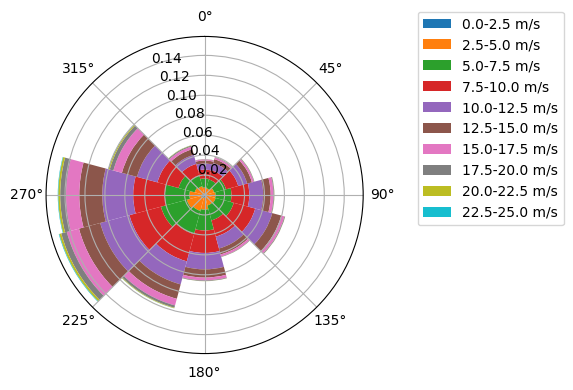

In [2]:
# visualise wind distribution
fig, ax = plt.subplots(figsize=(6, 4))
_ = utils.wfm_low.site.plot_wd_distribution(
    n_wd=len(utils.WD_DEFAULT),
    ws_bins=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25],
    ax=ax,
)
fig.tight_layout()

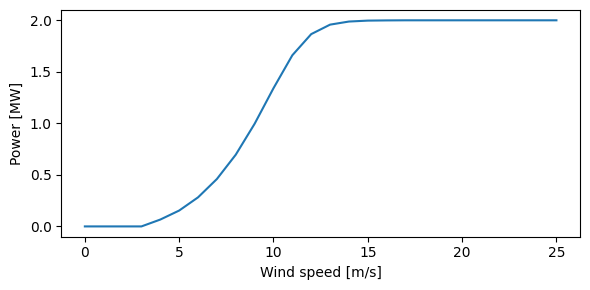

In [3]:
# visualise turbine power curve
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(utils.WS_DEFAULT, utils.wfm_low.windTurbines.power(utils.WS_DEFAULT) / 1e6)
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power [MW]")
fig.tight_layout()

## Baseline values
Summary values across all wind directions with no wake steering

In [4]:
# extract probabilities for full wind speed/direction range
_, Sector_frequency, P = utils.run_sim(
    wfm=utils.wfm_low,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=0,
    ws=utils.WS_DEFAULT,
    wd=utils.WD_DEFAULT,
)

In [5]:
# drop wind speeds below cut in speed
ind_cut_in = np.argmax(utils.wfm_low.windTurbines.power(utils.WS_DEFAULT) > 0)
ws = utils.WS_DEFAULT[ind_cut_in:]
logging.info(f"turbine cut in speed: {ws[0]:.2f}")

INFO:root:turbine cut in speed: 4.00


In [6]:
print("--- Low Fidelity ---")
sim_res_ref_low, _, _ = utils.run_sim(
    wfm=utils.wfm_low,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=0,
    ws=ws,
    wd=utils.WD_DEFAULT,
    Sector_frequency=Sector_frequency,
    P=P,
    show=True,
)

print("\n--- High Fidelity ---")
sim_res_ref_high, _, _ = utils.run_sim(
    wfm=utils.wfm_high,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=0,
    ws=ws,
    wd=utils.WD_DEFAULT,
    Sector_frequency=Sector_frequency,
    P=P,
    show=True,
)

--- Low Fidelity ---
Annual energy [GWh]: 78.081
LCoE [USD/MWh]: 45.100
Capacity factor [%]: 49.485

--- High Fidelity ---
Annual energy [GWh]: 78.556
LCoE [USD/MWh]: 44.827
Capacity factor [%]: 49.786


  0%|          | 0/12 [00:00<?, ?it/s]

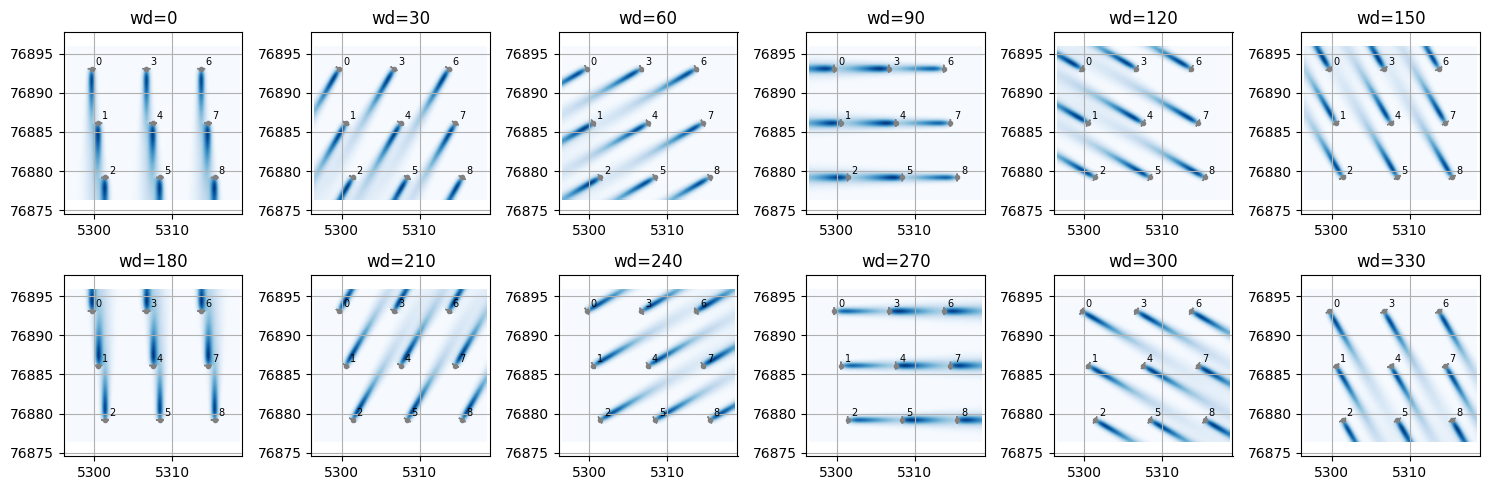

In [7]:
# plot flow maps
fig, ax_all = plt.subplots(ncols=6, nrows=2, figsize=(15, 5))
ws_ = 12
for wd_, ax in tqdm(
    zip(sim_res_ref_low.wd.values, ax_all.flatten()), total=len(sim_res_ref_low.wd)
):
    sim_res, _, _ = utils.run_sim(
        wfm=utils.wfm_low,
        x=utils.wt9_x,
        y=utils.wt9_y,
        yaw=0,
        ws=ws_,
        wd=[wd_],
        sim_res_ref=sim_res_ref_low.sel(wd=[wd_], ws=ws_),
        Sector_frequency=Sector_frequency,
        P=P,
    )
    fm = sim_res.flow_map()
    fm.plot_wake_map(
        plot_colorbar=False, normalize_with=utils.wfm_low.windTurbines.diameter(), ax=ax
    )
    ax.get_legend().remove()
    ax.grid()
    ax.set_title(f"wd={wd_}")

fig.tight_layout()

## Assess across coarse range for all turbines
Consider all combinations of a fixed yaw angle for each turbine in each direction. Assess impact on LCoE and capacity factor.

In [8]:
coarse_dir = os.path.join("data", "coarse_sweep.h5")
yaw_ind_coarse = {f"yaw_{i}": [-5, 0, 5] for i in sim_res_ref_low.wt.values}
if os.path.isfile(coarse_dir):
    # load pre-existing dataset
    ds_coarse = xr.open_dataset(coarse_dir)
else:
    # initialise dataset
    dims_all = ["wt", "wd"] + list(yaw_ind_coarse.keys())
    shape_all = (len(sim_res_ref_low.wt), len(sim_res_ref_low.wd)) + tuple(
        len(x) for x in yaw_ind_coarse.values()
    )
    dims_direction = dims_all[1:]
    shape_direction = shape_all[1:]
    dims_overall = dims_direction[1:]
    shape_overall = shape_direction[1:]
    ds_coarse = xr.Dataset(
        data_vars={
            "aep": (dims_all, np.full(shape_all, np.nan)),
            "lcoe": (dims_all, np.full(shape_all, np.nan)),
            "cap_fac": (dims_all, np.full(shape_all, np.nan)),
            "lcoe_direction": (dims_direction, np.full(shape_direction, np.nan)),
            "cap_fac_direction": (dims_direction, np.full(shape_direction, np.nan)),
            "lcoe_overall": (dims_overall, np.full(shape_overall, np.nan)),
            "cap_fac_overall": (dims_overall, np.full(shape_overall, np.nan)),
        },
        coords={
            "wt": list(sim_res_ref_low.wt.values),
            "wd": list(sim_res_ref_low.wd.values),
        }
        | yaw_ind_coarse,
    )
    # calculate across full range of options
    yaw_options_coarse = list(product(*yaw_ind_coarse.values()))
    simulations = {
        k: v
        for k, v in zip(
            yaw_options_coarse,
            pqdm(
                array=[
                    {
                        "wfm": utils.wfm_low,
                        "x": utils.wt9_x,
                        "y": utils.wt9_y,
                        "yaw": yaw,
                        "ws": ws,
                        "wd": utils.WD_DEFAULT,
                        "sim_res_ref": sim_res_ref_low,
                        "Sector_frequency": Sector_frequency,
                        "P": P,
                    }
                    for yaw in yaw_options_coarse
                ],
                function=utils.run_sim,
                n_jobs=int(0.75 * os.cpu_count()),
                argument_type="kwargs",
            ),
        )
    }
    # save results to dataset
    for yaw_option, (sim_res, _, _) in tqdm(
        simulations.items(), total=len(simulations), desc="Saving values to dataset"
    ):
        ds_coarse["aep"].loc[:, :, *yaw_option] = sim_res.energy
        ds_coarse["lcoe"].loc[:, :, *yaw_option] = sim_res.lcoe
        ds_coarse["cap_fac"].loc[:, :, *yaw_option] = sim_res.cap_fac
        ds_coarse["lcoe_direction"].loc[:, *yaw_option] = sim_res.lcoe_direction
        ds_coarse["cap_fac_direction"].loc[:, *yaw_option] = sim_res.cap_fac_direction
        ds_coarse["lcoe_overall"].loc[*yaw_option] = sim_res.lcoe_overall
        ds_coarse["cap_fac_overall"].loc[*yaw_option] = sim_res.cap_fac_overall
    # save file
    ds_coarse.to_netcdf(coarse_dir)

In [9]:
# identify optimum yaw angle for each turbine in each wind direction
yaw_opt_coarse = ds_coarse.lcoe_direction.stack(
    dimensions={"all_dims": yaw_ind_coarse.keys()}
).idxmin(dim="all_dims")
yaw_opt_coarse.to_dataframe().drop("all_dims", axis=1)

,yaw_0,yaw_1,yaw_2,yaw_3,yaw_4,yaw_5,yaw_6,yaw_7,yaw_8
wd,,,,,,,,,
0,5,5,0,5,5,0,5,5,0
30,0,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,-5,-5,0
90,0,0,0,0,0,0,5,5,5
120,0,0,0,0,0,0,0,5,5
150,0,0,0,0,0,5,0,0,5
180,0,5,5,0,5,5,0,5,5
210,0,0,0,0,0,0,0,0,0
240,0,-5,-5,0,0,0,0,0,0


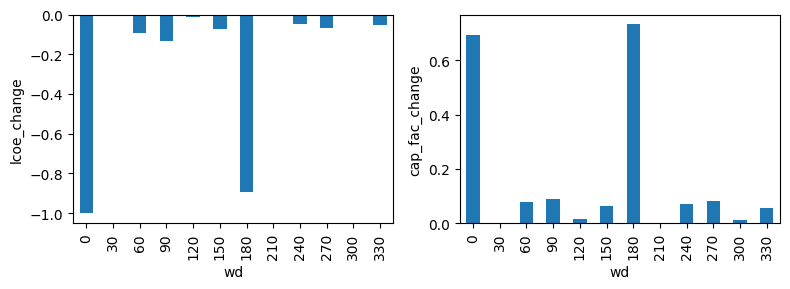

In [10]:
# plot improvements
fig, ax_all = plt.subplots(ncols=2, figsize=(8, 3))
(
    ds_coarse.lcoe_direction.min(list(yaw_ind_coarse.keys()))
    - ds_coarse.lcoe_direction.sel({k: 0 for k in yaw_ind_coarse})
).to_series().plot.bar(ax=ax_all[0])
ax_all[0].set_ylabel("lcoe_change")
(
    100
    * (
        ds_coarse.cap_fac_direction.max(list(yaw_ind_coarse.keys()))
        - ds_coarse.cap_fac_direction.sel({k: 0 for k in yaw_ind_coarse})
    )
).to_series().plot.bar(ax=ax_all[1])
ax_all[1].set_ylabel("cap_fac_change")
fig.tight_layout()

Observations
- Improvements observied in every direction but direction with existing offset and downstream turbines near to wake benefit most as they require only a small deviation
- Movement of last front row is pointless
- Middle rows don't seem to benefit from changing (in this coarse system anyway) but it be that the optimal yaw is small in comparison to the search grid

## Assess across fine range of yaw combinations for two turbines
Consider a range of yaw angles in either direction for two turbines (first and second turbine of row from westerly direction). Assess impact on LCoE and capacity factor.

In [11]:
fine_dir = os.path.join("data", "fine_sweep.h5")
yaw_ind_fine = {
    f"yaw_{i}": np.arange(-30, 30.5, 0.5) for i in sim_res_ref_low.wt.values[[1, 4]]
}
if os.path.isfile(fine_dir):
    # load pre-existing dataset
    ds_fine = xr.open_dataset(fine_dir)
else:
    # initialise dataset
    dims_all = ["wt", "wd"] + list(yaw_ind_fine.keys())
    shape_all = (len(sim_res_ref_low.wt), len(sim_res_ref_low.wd)) + tuple(
        len(x) for x in yaw_ind_fine.values()
    )
    dims_direction = dims_all[1:]
    shape_direction = shape_all[1:]
    dims_overall = dims_direction[1:]
    shape_overall = shape_direction[1:]
    ds_fine = xr.Dataset(
        data_vars={
            "aep": (dims_all, np.full(shape_all, np.nan)),
            "lcoe": (dims_all, np.full(shape_all, np.nan)),
            "cap_fac": (dims_all, np.full(shape_all, np.nan)),
            "lcoe_direction": (dims_direction, np.full(shape_direction, np.nan)),
            "cap_fac_direction": (dims_direction, np.full(shape_direction, np.nan)),
            "lcoe_overall": (dims_overall, np.full(shape_overall, np.nan)),
            "cap_fac_overall": (dims_overall, np.full(shape_overall, np.nan)),
        },
        coords={
            "wt": list(sim_res_ref_low.wt.values),
            "wd": list(sim_res_ref_low.wd.values),
        }
        | yaw_ind_fine,
    )
    # calculate across full range of options
    yaw_options_fine = list(
        product(*[yaw_ind_fine.get(f"yaw_{x}", [0]) for x in sim_res_ref_low.wt.values])
    )
    simulations = {
        k: v
        for k, v in zip(
            yaw_options_fine,
            pqdm(
                array=[
                    {
                        "wfm": utils.wfm_low,
                        "x": utils.wt9_x,
                        "y": utils.wt9_y,
                        "yaw": yaw,
                        "ws": ws,
                        "wd": utils.WD_DEFAULT,
                        "sim_res_ref": sim_res_ref_low,
                        "Sector_frequency": Sector_frequency,
                        "P": P,
                    }
                    for yaw in yaw_options_fine
                ],
                function=utils.run_sim,
                n_jobs=int(0.75 * os.cpu_count()),
                argument_type="kwargs",
            ),
        )
    }
    # save results to dataset
    for yaw_option, (sim_res, _, _) in tqdm(
        simulations.items(), total=len(simulations), desc="Saving values to dataset"
    ):
        ds_fine["aep"].loc[:, :, yaw_option[1], yaw_option[4]] = sim_res.energy
        ds_fine["lcoe"].loc[:, :, yaw_option[1], yaw_option[4]] = sim_res.lcoe
        ds_fine["cap_fac"].loc[:, :, yaw_option[1], yaw_option[4]] = sim_res.cap_fac
        ds_fine["lcoe_direction"].loc[
            :, yaw_option[1], yaw_option[4]
        ] = sim_res.lcoe_direction
        ds_fine["cap_fac_direction"].loc[
            :, yaw_option[1], yaw_option[4]
        ] = sim_res.cap_fac_direction
        ds_fine["lcoe_overall"].loc[yaw_option[1], yaw_option[4]] = sim_res.lcoe_overall
        ds_fine["cap_fac_overall"].loc[
            yaw_option[1], yaw_option[4]
        ] = sim_res.cap_fac_overall
    # save file
    ds_fine.to_netcdf(fine_dir)

In [12]:
# identify optimums for each wind direction

# calculate optimum for each direction
yaw_opt_fine = ds_fine.lcoe_direction.stack(
    dimensions={"all_dims": yaw_ind_fine.keys()}
).idxmin(dim="all_dims")
# fill out 0 values for unoptimised turbines
data_list = []
for vals in yaw_opt_fine.values:
    yaw_opt = list((0,) * len(ds_fine.wt))
    yaw_opt[1], yaw_opt[4] = vals
    data_list.append(tuple(yaw_opt))
data = np.empty(len(data_list), dtype=object)
data[:] = data_list
# store as dataarray
yaw_opt_fine = xr.DataArray(data=data, coords={"wd": yaw_opt_fine.wd.values})

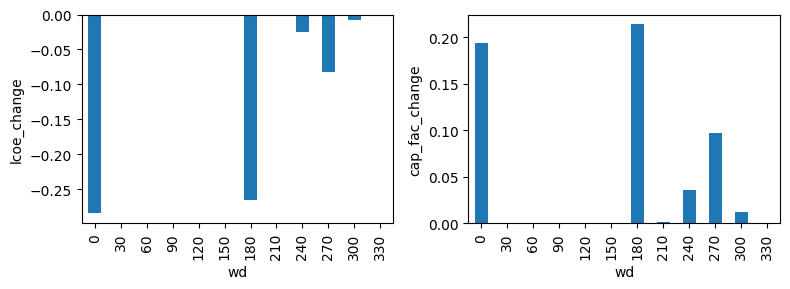

In [13]:
# plot improvements
fig, ax_all = plt.subplots(ncols=2, figsize=(8, 3))
(
    ds_fine.lcoe_direction.min(list(yaw_ind_fine.keys()))
    - ds_fine.lcoe_direction.sel(yaw_1=0, yaw_4=0)
).to_series().plot.bar(ax=ax_all[0])
ax_all[0].set_ylabel("lcoe_change")
(
    100
    * (
        ds_fine.cap_fac_direction.max(list(yaw_ind_fine.keys()))
        - ds_fine.cap_fac_direction.sel(yaw_1=0, yaw_4=0)
    )
).to_series().plot.bar(ax=ax_all[1])
ax_all[1].set_ylabel("cap_fac_change")
fig.tight_layout()

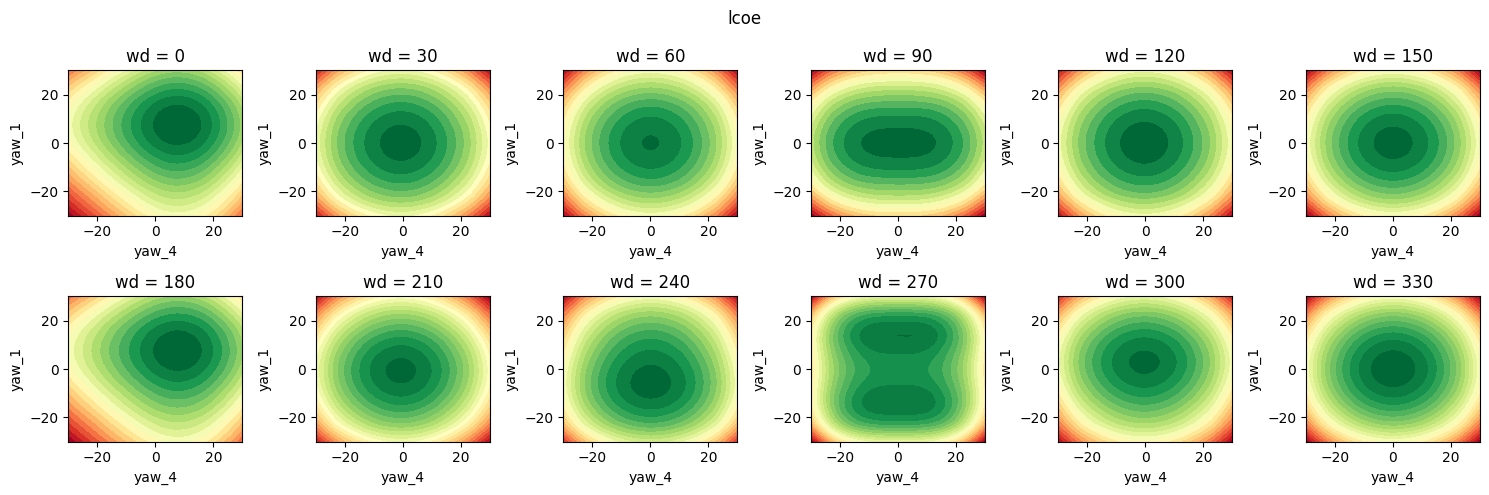

In [14]:
# plot distribution of lcoe values
fig, ax_all = plt.subplots(ncols=6, nrows=2, figsize=(15, 5))
for wd, ax in zip(ds_fine.wd, ax_all.flatten()):
    _ = ds_fine.lcoe_direction.sel(wd=wd.values).plot.contourf(
        levels=25,
        ax=ax,
        add_colorbar=False,
        cmap="RdYlGn_r",
    )
fig.suptitle("lcoe")
fig.tight_layout()

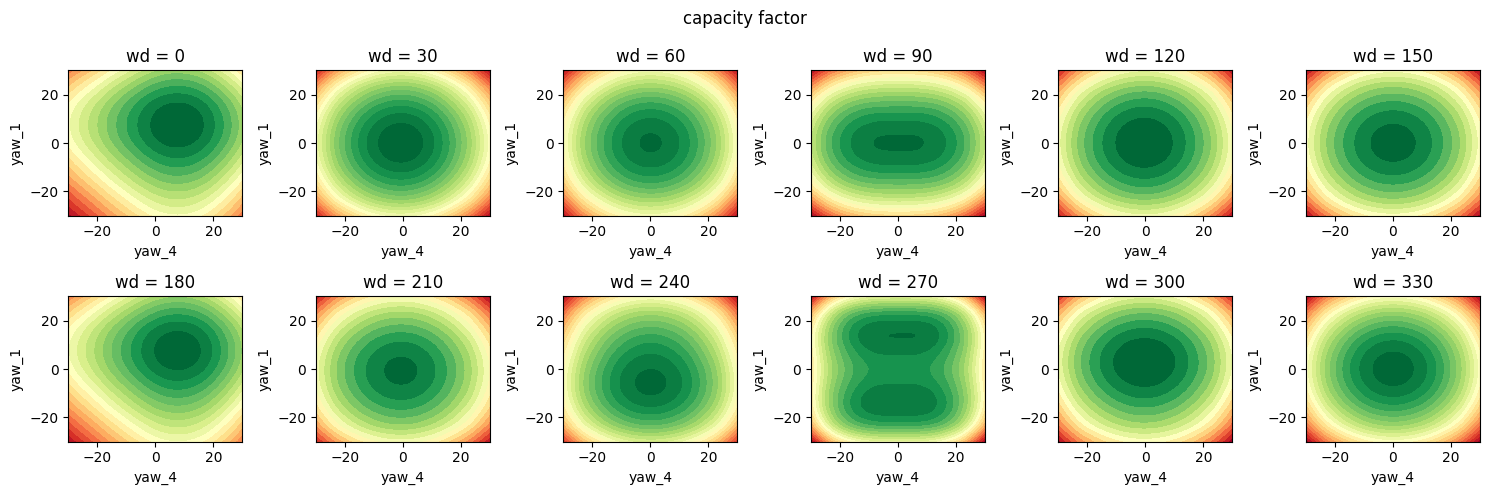

In [15]:
# plot distribution of cap_fac values
fig, ax_all = plt.subplots(ncols=6, nrows=2, figsize=(15, 5))
for wd, ax in zip(ds_fine.wd, ax_all.flatten()):
    _ = (100 * ds_fine.cap_fac_direction.sel(wd=wd.values)).plot.contourf(
        levels=25,
        ax=ax,
        add_colorbar=False,
        cmap="RdYlGn",
    )
fig.suptitle("capacity factor")
fig.tight_layout()

[13.5, 3.0, 0]


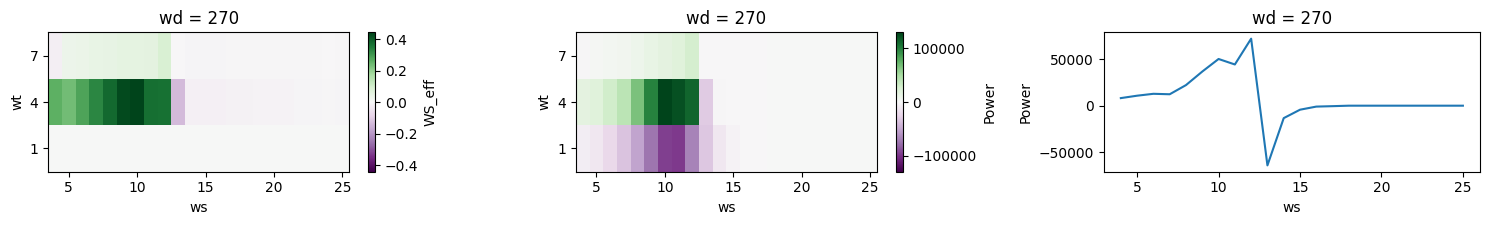

In [16]:
# plot distribution of wind speed and power changes
wd_ = 270
turbines = [1, 4, 7]
print(
    [x for i, x in enumerate(yaw_opt_fine.sel(wd=wd_).values.tolist()) if i in turbines]
)
sim_res_opt_fine, _, _ = utils.run_sim(
    wfm=utils.wfm_low,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=yaw_opt_fine.sel(wd=wd_).values.tolist(),
    ws=ws,
    wd=[wd_],
    Sector_frequency=Sector_frequency,
    P=P,
)
fig, ax = plt.subplots(ncols=3, figsize=(15, 2.5))
WS_eff_diff = (sim_res_opt_fine.WS_eff - sim_res_ref_low.WS_eff).sel(wt=turbines)
Power_diff = (sim_res_opt_fine.Power - sim_res_ref_low.Power).sel(wt=turbines)
WS_eff_diff.plot(cmap="PRGn", ax=ax[0])
Power_diff.plot(cmap="PRGn", ax=ax[1])
Power_diff.sum("wt").plot(ax=ax[2])
ax[0].set_yticks(WS_eff_diff.wt)
ax[1].set_yticks(Power_diff.wt)
fig.suptitle("")
fig.tight_layout()

Observations
- Direction of yaw favours prexisting offset if one exists
- Considerable improvements observed even with diagonal wind directions which already have better spacing between wakes
- Off design performance is good - not too sensitive near optimum
- Improvements increase with wind speed until maximal power output
    - Near maximal power output speed the increase of the second turbine is minimal as the power curve flattens so a net loss is observed
- Optimal yaw likely a function of wind speed and direction
    - Change with speed appears smoother than changes with direction

## Compare low and high fidelity model
Using the same yaw values optimised using a low fidelity model, compare the benefits as calculated by the low and high fidelity model

In [17]:
# high fidelity simulation for yaw values calculated using low fidelity model
sim_res_opt_fine_high, _, _ = utils.run_sim(
    wfm=utils.wfm_high,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=np.array(yaw_opt_fine.values.tolist()).T,
    ws=ws,
    wd=utils.WD_DEFAULT,
    sim_res_ref=sim_res_ref_high,
    Sector_frequency=Sector_frequency,
    P=P,
)

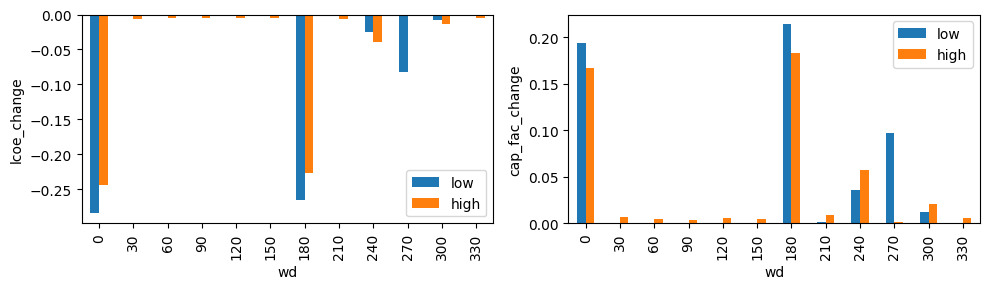

In [18]:
# plot improvements
fig, ax_all = plt.subplots(ncols=2, figsize=(10, 3))
lcoe_improvement = (
    (
        ds_fine.lcoe_direction.min(list(yaw_ind_fine.keys()))
        - ds_fine.lcoe_direction.sel(yaw_1=0, yaw_4=0)
    )
    .to_series()
    .to_frame(name="low")
)
lcoe_improvement["high"] = (
    sim_res_opt_fine_high - sim_res_ref_high
).lcoe_direction.to_series()
lcoe_improvement.plot.bar(ax=ax_all[0])
ax_all[0].set_ylabel("lcoe_change")
cap_fac_improvement = (
    (
        ds_fine.cap_fac_direction.max(list(yaw_ind_fine.keys()))
        - ds_fine.cap_fac_direction.sel(yaw_1=0, yaw_4=0)
    )
    .to_series()
    .to_frame(name="low")
)
cap_fac_improvement["high"] = (
    sim_res_opt_fine_high - sim_res_ref_high
).cap_fac_direction.to_series()
(100 * cap_fac_improvement).plot.bar(ax=ax_all[1])
ax_all[1].set_ylabel("cap_fac_change")
fig.tight_layout()

Observations
- Optimum values are similar for low and high fidelity model (apart from head on)
- Neither model consistently under/over predicts